# Семинар 6. Выбор модели. Кросс-валидация. Отбор признаков

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()
        
    return (mae, mse, rmse, mape, r2)

# Задача выбора модели

* __Настройка гиперпараметров:__ для конкретного вида модели выбрать наилучшие гиперпараметры (параметры обучения).
* __Выбор вида модели и алгоритма обучения:__ выбрать один из альтернативных видов модели.
* __Отбор признаков:__ отбросить неинформативные признаки.

# 1. Настройка гиперпараметров

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [3]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


Данные к обучению:

In [4]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

## 1.1. Метод отложенной выборки

* Делим датасет на 3 части:
    * __Train__ -- используется для обучения параметров модели.
    * __Valid__ -- используется для оценки обобщающей способности модели и для отбора гиперпараметров.
    * __Test__ -- используется для финальной оценки качества алгоритма.

In [5]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


Преобразование признаков и модель:

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(drop='first'), cat_features))
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['origin'])])

In [7]:
from sklearn.linear_model import Ridge


estimator = Ridge(alpha=1e-3)
estimator

Ridge(alpha=0.001)

In [8]:
from sklearn.pipeline import make_pipeline


model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

Печатаем метрики:

Train:
MAE:  1.0065714456298274
MSE:  1.8271676990014456
RMSE: 1.3517276719078608
MAPE: 0.09233814607795612
R2:   0.888276001098649

Valid:
MAE:  0.933371574464639
MSE:  1.5088999890361994
RMSE: 1.2283729030861106
MAPE: 0.09445970413429358
R2:   0.808376611496636



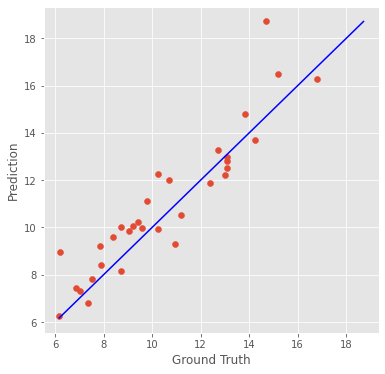

(0.933371574464639,
 1.5088999890361994,
 1.2283729030861106,
 0.09445970413429358,
 0.808376611496636)

In [9]:
print('Train:')
regression_metrics(y_train, pred_train, verbose=True)

print('Valid:')
regression_metrics(y_valid, pred_valid, verbose=True, plot=True)

Выбор гиперпараметров:


Best alpha: 44.22514763163044
Idx of best alpha: 118


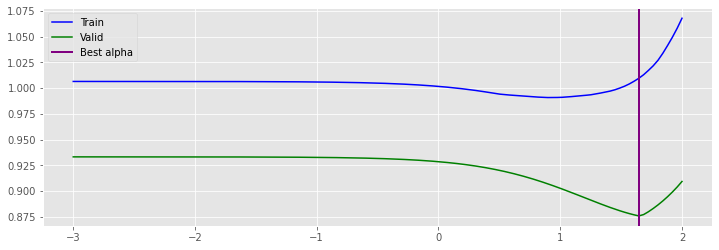

In [10]:
# Best MAE
from tqdm.auto import tqdm


def func(alpha):
    model = make_pipeline(transformer, Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    
    score = mean_absolute_error
    
    metrics_train = score(y_train, model.predict(X_train))
    metrics_valid = score(y_valid, model.predict(X_valid))
    return metrics_train, metrics_valid

alpha_list = np.logspace(-3, 2, 128)
metrics_list = [func(alpha) for alpha in tqdm(alpha_list)]
train_list, valid_list = zip(*metrics_list)

best_idx = np.argmin(valid_list)
alpha_best = alpha_list[best_idx]
print('Best alpha:', alpha_best)
print('Idx of best alpha:', best_idx)

plt.plot(np.log10(alpha_list), train_list, color='blue', label='Train')
plt.plot(np.log10(alpha_list), valid_list, color='green', label='Valid')
plt.axvline(np.log10(alpha_best), color='purple', lw=2, label='Best alpha')
plt.legend()
plt.show()

Обучаем итоговую модель:

In [11]:
estimator = Ridge(alpha=alpha_best)

model = make_pipeline(transformer, estimator)
model.fit(X_fit, y_fit)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=44.22514763163044))])

Fit:
MAE:  0.9926126530297403
MSE:  1.9492897682964878
RMSE: 1.396169677473511
MAPE: 0.09046292873991105
R2:   0.874638841932597

Test:
MAE:  0.9272767346617419
MSE:  1.6592567207775493
RMSE: 1.2881213920968588
MAPE: 0.08099501762559672
R2:   0.8829842270316925



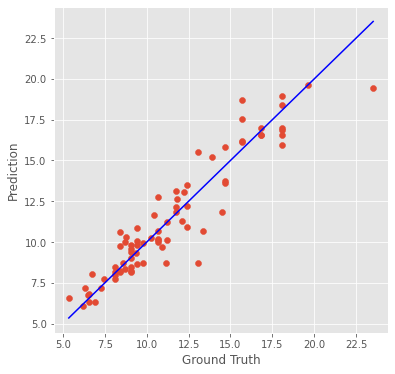

(0.9272767346617419,
 1.6592567207775493,
 1.2881213920968588,
 0.08099501762559672,
 0.8829842270316925)

In [12]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

## 1.2. Кросс-валидация

Цели:
* Выбор модели.
* Оценка качества.

Основные разновидности кросс-валидации:
* __Leave One Out:__ 
    * по очереди откладываем одно наблюдение для оценки;
    * обучаем на всей выборке кроме выбранного наблюдения;
    * считаем метрики на отложенном наблюдении.
* __K-Fold:__
    * делим на $k$ непересекающихся групп (fold-ов);
    * далее аналогично Leave One Out.
* __Repeated K-Fold:__
    * несколько раз с разными разбиениями повторяется K-Fold.
* __Stratified K-Fold:__
    * Разбиения пропорционально категориальному признаку (распределение по категориям в fold-ах будет похожим).
* __Grouped K-Fold:__
    * Если одному объекту принадлежит несколько наблюдений (например, пользователь померил несколько моделей обуви).

In [13]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


$L_2$-регуляризация с кросс-валидацией:

In [14]:
from sklearn.linear_model import RidgeCV


estimator = RidgeCV(alphas=np.logspace(-3, 2, 64))
model = make_pipeline(transformer, estimator)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.20050806e-03, 1.44121960e-03, 1.73019574e-03,
       2.07711393e-0...
       1.49486913e+00, 1.79460244e+00, 2.15443469e+00, 2.58641621e+00,
       3.10501350e+00, 3.72759372e+00, 4.47500630e+00, 5.37228112e+00,
       6.44946677e+00, 7.74263683e+00, 9.29509790e+00, 1.11588399e+01,
       1

Настраиваем гиперпараметры и смотрим на качество модели:

In [15]:
model.fit(X_fit, y_fit)

print('Best alpha:', model['ridgecv'].alpha_)
print('Coefs:', model['ridgecv'].coef_)

Best alpha: 2.154434690031882
Coefs: [-0.49562088  1.08978765  1.979628    0.23120289  0.58091994 -1.1687093
  0.15679769  0.77167686]


Fit:
MAE:  0.9853606796923264
MSE:  1.793282315748946
RMSE: 1.339134913199169
MAPE: 0.09092546627851082
R2:   0.8846718679283148

Test:
MAE:  0.9718889261142355
MSE:  1.5602084197707857
RMSE: 1.2490830315758779
MAPE: 0.08740506806223337
R2:   0.8899694110350894



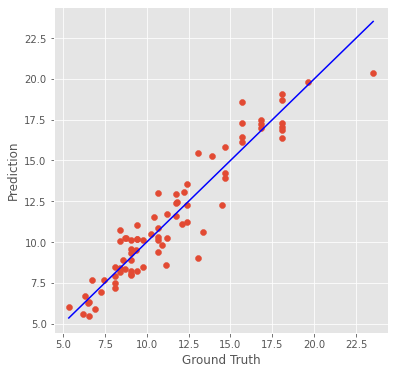

(0.9718889261142355,
 1.5602084197707857,
 1.2490830315758779,
 0.08740506806223337,
 0.8899694110350894)

In [16]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

# 1.3. GridSearch

Умеет перебирать все возможные гипер-параметры и находить оптимальные для произвольных алгоритмов машинного обучения.

In [17]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


In [18]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(Ridge(), {
    'alpha': np.logspace(-3, 2, 32),
    'solver': ('svd', 'cholesky', 'lsqr')
})

model = make_pipeline(transformer, grid_search)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('gridsearchcv',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-03, 1.44974067e-03, 2....
       1.95129342e-02, 2.82886943e-02, 4.10112707e-02, 5.94557071e-02,
       8.61953566e-02, 1.24960914e-01, 1.81160919e-01, 2.62636353e-01,
       3.80754602e-01, 5.51995432e-01, 8.00250228e-01, 1

In [19]:
model.fit(X_fit, y_fit)
model['gridsearchcv'].best_estimator_

Ridge(alpha=3.5349811050301057, solver='lsqr')

Fit:
MAE:  0.9821045073394921
MSE:  1.7984240145187897
RMSE: 1.341053322772361
MAPE: 0.09053643858843877
R2:   0.8843411991264236

Test:
MAE:  0.9669734130451547
MSE:  1.5631130532786452
RMSE: 1.250245197262779
MAPE: 0.08670568528090154
R2:   0.8897645675465227



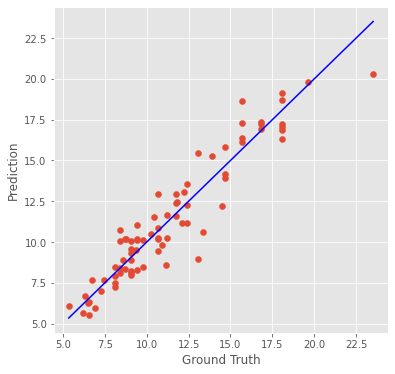

(0.9669734130451547,
 1.5631130532786452,
 1.250245197262779,
 0.08670568528090154,
 0.8897645675465227)

In [20]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

GridSearch для всего пайплайна:

# 2. Выбор вида модели

__Задача:__ отобрать параметры для метода $k$ ближайших соседей.

__Задача:__ 
* обучить понравившуюся Вам модель и подобрать к ней гиперпараметры;
* выбрать метрику качества и сравнить с KNN.

# 3. Отбор признаков

Sklearn обладает инструментами для отбора признаков ([ссылка на документацию](https://scikit-learn.org/stable/modules/feature_selection.html)).

* Удаление признаков с малой дисперсией.
* Отбор признаков с помощью статистических критериев.
* С помощью $L_1$ регуляризации.
* Рекурсивный отбор признаков.
* Последовательный отбор признаков.

In [24]:
from sklearn.feature_selection import (
    f_regression,
    SelectKBest,
    SelectFromModel,
    RFE,
    SequentialFeatureSelector
)

In [25]:
X_fit.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
260,6,3.687098,110.0,1.642003,18.7,78,usa
184,4,2.294194,92.0,1.166639,14.9,76,usa
174,6,2.802194,97.0,1.353519,14.5,75,usa
64,8,5.211098,150.0,1.875603,13.5,72,usa
344,4,1.409291,64.0,0.850485,16.4,81,usa


Выбор с помощью модели:

In [85]:
from sklearn.linear_model import LinearRegression


features = np.random.normal(size=(128, 16))
targets = 0.1 + 0.05 * features[:, 0] + 0.02 * features[:, 2] - 0.1 * features[:, 4] + np.random.normal(scale=1)

In [86]:
selector = SelectFromModel(LinearRegression(), max_features=16)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

array([[ 1.57946646, -0.58331852, -1.85160961],
       [-3.52544447, -0.24937343, -0.05036734],
       [ 0.47175092, -0.16055772, -1.00397738],
       [-0.40246712, -0.21318851, -0.02120482],
       [ 0.2841426 ,  2.07016317, -0.63121291]])

Рекурсивный отбор признаков:

In [87]:
selector = RFE(LinearRegression(), n_features_to_select=6)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False,  True, False,
       False, False, False,  True, False,  True, False])

array([[ 1.57946646, -0.58331852, -1.85160961,  0.28607153,  1.54774964,
         1.61474482],
       [-3.52544447, -0.24937343, -0.05036734,  0.40935046, -0.05787155,
        -0.64447466],
       [ 0.47175092, -0.16055772, -1.00397738, -1.54463634, -0.04894699,
         0.78895798],
       [-0.40246712, -0.21318851, -0.02120482, -0.91390034,  1.52151852,
        -0.12973945],
       [ 0.2841426 ,  2.07016317, -0.63121291, -0.23404554,  0.64571501,
        -1.3703297 ]])

In [84]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

array([[ 1.60658821,  0.56629095,  0.27101743],
       [-0.25242325,  1.60528839,  0.75639134],
       [-0.23898925,  2.19288568,  0.65996421],
       [ 0.45374792, -0.15253493,  0.59766123],
       [ 0.11596135, -0.18126775, -0.86634457]])

Встраиваем в Pipeline:

Fit:
MAE:  1.3129402454989323
MSE:  2.888925131084569
RMSE: 1.6996838326831756
MAPE: 0.1233924834791669
R2:   0.8150454182898251

Test:
MAE:  1.1308429534125066
MSE:  2.3477503194418583
RMSE: 1.532237031089465
MAPE: 0.11707061829071402
R2:   0.8247106354041729



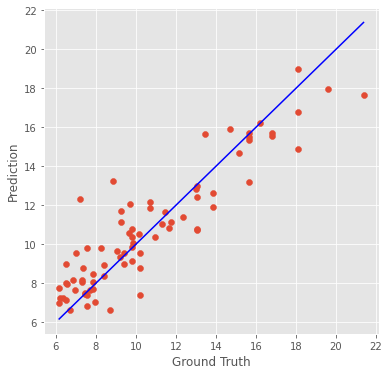

(1.1308429534125066,
 2.3477503194418583,
 1.532237031089465,
 0.11707061829071402,
 0.8247106354041729)

In [77]:
selector = SelectKBest(score_func=f_regression, k=5)
estimator = LinearRegression()

model = make_pipeline(transformer, selector, estimator)
model.fit(X_fit, y_fit)

print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

In [91]:
selector = SelectKBest(score_func=f_regression, k=1)
estimator = Ridge()

pipeline = make_pipeline(transformer, selector, estimator)
pipeline.fit(X_fit, y_fit)

model = GridSearchCV(pipeline, {
    'ridge__alpha': np.logspace(-4, 3, 16),
    'ridge__fit_intercept': [False, True],
    'columntransformer__standardscaler__with_mean': [False, True],
    'selectkbest__k': list(range(1, 9))
}, verbose=1, n_jobs=16)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x13df0bef0>)),
                ('ridge', Ridge(alpha=39.81071705534969))])

In [92]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True)

Fit:
MAE:  1.0058292924316232
MSE:  1.9669332243387718
RMSE: 1.40247396565454
MAPE: 0.09036298669511746
R2:   0.8740731257293446

Test:
MAE:  0.9082718296890542
MSE:  1.5618446382019242
RMSE: 1.2497378277870619
MAPE: 0.08915156807783485
R2:   0.8833884710990475



(0.9082718296890542,
 1.5618446382019242,
 1.2497378277870619,
 0.08915156807783485,
 0.8833884710990475)

# 4. Оценка качества модели на кросс-валидации

In [93]:
estimator = Ridge(alpha=0.01)
model = make_pipeline(transformer, estimator)

In [94]:
from sklearn.model_selection import KFold


cv = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = []

for fit_index, test_index in cv.split(X, y):
    X_fit = X.iloc[fit_index]
    X_test = X.iloc[test_index]
    
    y_fit = y.iloc[fit_index]
    y_test = y.iloc[test_index]
    
    model.fit(X_fit, y_fit)
    pred_test = model.predict(X_test)
    
    metrics.append(regression_metrics(y_test, pred_test))
    
metrics = pd.DataFrame(metrics, columns=['mae', 'mse', 'rmse', 'mape', 'r2'])
metrics

,mae,mse,rmse,mape,r2
0,0.981373,1.561772,1.249709,0.088764,0.889859
1,0.987270,1.809605,1.345215,0.091567,0.856615
2,1.117476,2.472154,1.572308,0.101970,0.861524
3,1.031640,1.929441,1.389043,0.091670,0.889927
4,0.899956,1.475619,1.214751,0.086569,0.889826


In [95]:
metrics.mean()

mae     1.003543
mse     1.849718
rmse    1.354205
mape    0.092108
r2      0.877550
dtype: float64

Из коробки:

In [96]:
from sklearn.model_selection import cross_val_score


cv_result = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
cv_result

array([-1.5617725 , -1.80960454, -2.47215384, -1.92944142, -1.47561944])

In [97]:
cv_result.mean()

-1.8497183466864513

Несколько метрик:

In [98]:
from sklearn.model_selection import cross_validate


cv_result = cross_validate(model, X, y, cv=cv, 
                           scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])
cv_result

{'fit_time': array([0.01075983, 0.00897527, 0.00811911, 0.00996113, 0.00974393]),
 'score_time': array([0.007092  , 0.00490379, 0.00518584, 0.00558305, 0.00507903]),
 'test_neg_mean_absolute_error': array([-0.98137253, -0.98726984, -1.11747559, -1.03163999, -0.89995615]),
 'test_neg_mean_squared_error': array([-1.5617725 , -1.80960454, -2.47215384, -1.92944142, -1.47561944]),
 'test_r2': array([0.88985911, 0.85661502, 0.86152436, 0.88992746, 0.88982628])}

In [99]:
{k: np.mean(v) for k, v in cv_result.items()}

{'fit_time': 0.009511852264404297,
 'score_time': 0.005568742752075195,
 'test_neg_mean_absolute_error': -1.0035428172718521,
 'test_neg_mean_squared_error': -1.8497183466864513,
 'test_r2': 0.8775504450675523}